## Connect with Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Use to see if notebook is running on GPU
tf.config.list_physical_devices('GPU')

Num GPUs Available:  0


[]

## Load data

In [5]:
train_data_4D = np.load('/content/drive/MyDrive/analysis/spectograms/cnn_model_input/Pat2_train_data_4D.npy')
train_label = np.load('/content/drive/MyDrive/analysis/spectograms/cnn_model_input/Pat2_train_label.npy')

devtest_data_4D = np.load('/content/drive/MyDrive/analysis/spectograms/cnn_model_input/Pat2_devtest_data_4D.npy')
devtest_label = np.load('/content/drive/MyDrive/analysis/spectograms/cnn_model_input/Pat2_devtest_label.npy')

test_data_4D = np.load('/content/drive/MyDrive/analysis/spectograms/cnn_model_input/Pat2_test_data_4D.npy')
test_label = np.load('/content/drive/MyDrive/analysis/spectograms/cnn_model_input/Pat2_test_label.npy')


In [6]:
print(np.shape(train_data_4D))
print(np.shape(train_label))

print(np.shape(devtest_data_4D))
print(np.shape(devtest_label))

print(np.shape(test_data_4D))
print(np.shape(test_label))


(7639, 129, 48, 16)
(7639,)
(2227, 129, 48, 16)
(2227,)
(2429, 129, 48, 16)
(2429,)


## Build Model

In [7]:
def build_model(lr=0.001, momentum=0.9):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(129, 48,16)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='sigmoid'))

    opt = tf.keras.optimizers.SGD(
        learning_rate=lr, momentum=momentum, nesterov=True,
    )
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics='binary_accuracy')
    return model

In [8]:
def get_class_weight(train_label):
  "treat every instance of class 1 as 3 instances of class 0 means that in your loss function you assign higher value to these instances."
  count_arr =np.bincount(train_label)
  class_weight = {0: 1.,
                1: int(count_arr[0] / count_arr[1])}
  return class_weight

In [9]:
def run_model(train_data_4D, devtest_data_4D, test_data_4D, train_label,devtest_label,test_label):
    model = build_model()
    num_classes = 2
    train_set_labels_ = to_categorical(train_label, num_classes).astype(np.float32)
    devtest_set_labels_ = to_categorical(devtest_label, num_classes).astype(np.float32)
    test_set_labels_ = to_categorical(test_label, num_classes).astype(np.float32)
    class_weight = get_class_weight(train_label)
    history = model.fit(train_data_4D,train_set_labels_,batch_size=20,epochs=10,shuffle=False,validation_data=(devtest_data_4D,devtest_set_labels_),class_weight=class_weight)
    score = model.evaluate(test_data_4D, test_set_labels_, batch_size=20)
    print(f'Test loss: {score[0]} / Test accuracy: {score[1]}') 
    return model, history

## Run Model

In [10]:
model, history = run_model(train_data_4D, devtest_data_4D, test_data_4D, train_label,devtest_label,test_label)

Epoch 1/10
382/382 [==============================] - 207s 540ms/step - loss: 21.6525 - binary_accuracy: 0.4232 - val_loss: 0.6993 - val_binary_accuracy: 0.0876
Epoch 2/10
382/382 [==============================] - 207s 543ms/step - loss: 9.2742 - binary_accuracy: 0.5221 - val_loss: 0.8293 - val_binary_accuracy: 0.0889
Epoch 3/10
382/382 [==============================] - 206s 540ms/step - loss: 1.3310 - binary_accuracy: 0.2803 - val_loss: 0.7335 - val_binary_accuracy: 0.7261
Epoch 4/10
382/382 [==============================] - 206s 538ms/step - loss: 0.9792 - binary_accuracy: 0.8965 - val_loss: 0.6666 - val_binary_accuracy: 0.9079
Epoch 5/10
382/382 [==============================] - 205s 537ms/step - loss: 1.6082 - binary_accuracy: 0.8896 - val_loss: 0.6533 - val_binary_accuracy: 0.9142
Epoch 6/10
382/382 [==============================] - 200s 522ms/step - loss: 0.9671 - binary_accuracy: 0.8860 - val_loss: 0.6363 - val_binary_accuracy: 0.9176
Epoch 7/10
382/382 [===================

## Plots

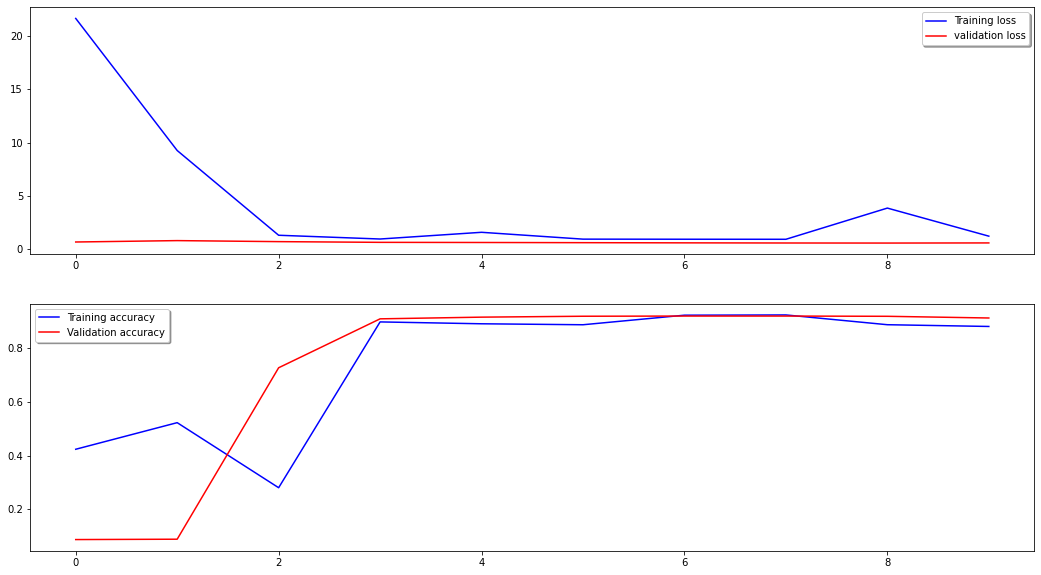

In [11]:
 # Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['binary_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_binary_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)